In [1]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import math

In [2]:
# CARGAMOS LOS RETORNOS DE TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
returns = pd.read_csv('ibex_historical_returns.csv',index_col='date')
returns.index = pd.to_datetime(returns.index)
returns.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,NaN,NaN,NaN,NaN,NaN,0.000831,NaN,NaN,NaN,0.023395,...,NaN,NaN,NaN,NaN,0.025183,NaN,NaN,NaN,NaN,0.016909
1993-08-18,NaN,NaN,NaN,NaN,NaN,-0.002079,NaN,NaN,NaN,0.003814,...,NaN,NaN,NaN,NaN,0.027093,NaN,NaN,NaN,NaN,0.012458
1993-08-19,NaN,NaN,NaN,NaN,NaN,-0.004088,NaN,NaN,NaN,-0.009661,...,NaN,NaN,NaN,NaN,-0.021590,NaN,NaN,NaN,NaN,0.007611
1993-08-20,NaN,NaN,NaN,NaN,NaN,-0.007048,NaN,NaN,NaN,-0.005882,...,NaN,NaN,NaN,NaN,-0.005504,NaN,NaN,NaN,NaN,-0.000402
1993-08-23,NaN,NaN,NaN,NaN,NaN,-0.002867,NaN,NaN,NaN,-0.027700,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,-0.003132


In [3]:
# CARGAMOS LOS DATOS DE PRECIOS DE CIERRE AJUSTADO PARA TODOS LOS ACTIVOS QUE HAN PERTENECIDO AL IBEX35 Y EL BENCHMARK
prices = pd.read_csv('ibex_historical_data.csv', index_col='date')
prices.index = pd.to_datetime(prices.index)
prices.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-16,NaN,NaN,NaN,NaN,NaN,1.2025,NaN,NaN,NaN,3.4515,...,NaN,NaN,NaN,NaN,2.9683,NaN,NaN,NaN,NaN,3113.896729
1993-08-17,NaN,NaN,NaN,NaN,NaN,1.2035,NaN,NaN,NaN,3.5332,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3166.996826
1993-08-18,NaN,NaN,NaN,NaN,NaN,1.2010,NaN,NaN,NaN,3.5467,...,NaN,NaN,NaN,NaN,3.1276,NaN,NaN,NaN,NaN,3206.696777
1993-08-19,NaN,NaN,NaN,NaN,NaN,1.1961,NaN,NaN,NaN,3.5126,...,NaN,NaN,NaN,NaN,3.0608,NaN,NaN,NaN,NaN,3231.196777
1993-08-20,NaN,NaN,NaN,NaN,NaN,1.1877,NaN,NaN,NaN,3.4920,...,NaN,NaN,NaN,NaN,3.0440,NaN,NaN,NaN,NaN,3229.896729


In [4]:
# CARGAMOS LOS DATOS DE LA TASA DE RETORNO DE LOS BONOS A 3 MESES DE LOS EEUU
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [13]:
def locate_in_df(df, value):
    a = df.to_numpy()
    row = np.where(a == value)[0][0]
    col = np.where(a == value)[1][0]
    return row, col
locate_in_df(returns,returns.min().min()), returns.min().min()

((6364, 32), -0.5485728680717057)

In [12]:
# prices.iloc[5136:,36] = np.nan
# returns.iloc[5135:,36] = np.nan
# prices.iloc[5626:, 2] = np.nan
# returns.iloc[5625:, 2] = np.nan

In [15]:
# DEFINIMOS UNA CANTIDAD DE DIAS PARA LA VENTANA DE CALCULO DE LOS RETORNOS
DIAS = 90
# DEFINIMOS LA CANTIDAD MAXIMA DE ACTIVOS QUE HABRAN EN NUESTRO RANKING
ACTIVOS = 10

Debemos completar los retornos de manera que nos permita no tener un dataset con muchos valores nulos y así poder analizarlo correctamente. Hay varias opciones 
a la hora de completar los datos nulos:
1) Completar el dataset de retornos con un retorno constante en los días en los que no haya cotizado dicho activo. Dentro de esta solución hay varias opciones:
    - Completar con ceros
    - Completar con -1
    - Completar el dataset con el peor retorno diario de todo el dataset y multiplicarlo por una constante para evitar que se cruce con el activo de peor retorno
2) Completar el dataset hacia adelante con el último retorno que haya tenido y hacia atrás con el primer retorno que haya tenido
3) Completar el dataset con el peor retorno de cada día y multiplicarlo por una constante para evitar que se cruce con el activo de peor retorno

Probemos opciones:

#### COMPLETAR CON RETORNOS A CERO

In [17]:
returns_completed_zero = returns.apply(lambda x: x.fillna(0), axis=1)
returns_completed_zero.head()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL,benchmark
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,0.0,0.0,0.0,0.0,0.0,0.000831,0.0,0.0,0.0,0.023395,...,0.0,0.0,0.0,0.0,0.025183,0.0,0.0,0.0,0.0,0.016909
1993-08-18,0.0,0.0,0.0,0.0,0.0,-0.002079,0.0,0.0,0.0,0.003814,...,0.0,0.0,0.0,0.0,0.027093,0.0,0.0,0.0,0.0,0.012458
1993-08-19,0.0,0.0,0.0,0.0,0.0,-0.004088,0.0,0.0,0.0,-0.009661,...,0.0,0.0,0.0,0.0,-0.021590,0.0,0.0,0.0,0.0,0.007611
1993-08-20,0.0,0.0,0.0,0.0,0.0,-0.007048,0.0,0.0,0.0,-0.005882,...,0.0,0.0,0.0,0.0,-0.005504,0.0,0.0,0.0,0.0,-0.000402
1993-08-23,0.0,0.0,0.0,0.0,0.0,-0.002867,0.0,0.0,0.0,-0.027700,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.003132


El problema de esta solución es que así como tenemos retornos mayores a cero también tenemos retornos menores a cero. Como nuestra tarea será predecir un ranking
aquellos activos que tengan retorno cero podrían quedar con una mejor posicion dentro del ranking que aquellos que tengan un retorno menor. Por lo tanto debemos descartar esta opción

#### COMPLETAR CON RETORNOS A -1

In [18]:
returns.apply(lambda x: x.fillna(-1), axis=1).min().min()

-1.0

In [19]:
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns_completed_zero['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns_completed_zero['risk_free_rate'] = returns_completed_zero['risk_free_rate'].fillna(method='ffill')
adjusted_returns = (returns_completed_zero.iloc[:,:-2].T - returns_completed_zero['risk_free_rate']).T
adjusted_period_returns_mean = adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
adjusted_period_returns_std = adjusted_returns.rolling(DIAS, min_periods=DIAS).std()

(adjusted_period_returns_mean / adjusted_period_returns_std).dropna()

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-23,-48.396829,-48.396829,-48.396829,-48.396829,-48.396829,-2.273886,-48.396829,-48.396829,-48.396829,-2.005967,...,-48.396829,-48.396829,-48.396829,-48.396829,-48.396829,-1.612524,-48.396829,-48.396829,-48.396829,-48.396829
1993-12-27,-48.295048,-48.295048,-48.295048,-48.295048,-48.295048,-2.048608,-48.295048,-48.295048,-48.295048,-1.900063,...,-48.295048,-48.295048,-48.295048,-48.295048,-48.295048,-1.637805,-48.295048,-48.295048,-48.295048,-48.295048
1993-12-28,-48.394193,-48.394193,-48.394193,-48.394193,-48.394193,-1.976557,-48.394193,-48.394193,-48.394193,-1.900679,...,-48.394193,-48.394193,-48.394193,-48.394193,-48.394193,-1.677258,-48.394193,-48.394193,-48.394193,-48.394193
1993-12-29,-48.530431,-48.530431,-48.530431,-48.530431,-48.530431,-1.960554,-48.530431,-48.530431,-48.530431,-1.871202,...,-48.530431,-48.530431,-48.530431,-48.530431,-48.530431,-1.678116,-48.530431,-48.530431,-48.530431,-48.530431
1993-12-30,-48.530431,-48.530431,-48.530431,-48.530431,-48.530431,-1.853386,-48.530431,-48.530431,-48.530431,-1.843332,...,-48.530431,-48.530431,-48.530431,-48.530431,-48.530431,-1.656394,-48.530431,-48.530431,-48.530431,-48.530431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,-32.851472,-32.851472,-32.851472,-32.851472,-4.596245,-32.851472,-3.615628,-4.365863,-32.851472,-32.851472,...,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472,-32.851472
2023-08-08,-34.258143,-34.258143,-34.258143,-34.258143,-4.686822,-34.258143,-3.670260,-4.427830,-34.258143,-34.258143,...,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143,-34.258143
2023-08-09,-36.040823,-36.040823,-36.040823,-36.040823,-4.710506,-36.040823,-3.672954,-4.423542,-36.040823,-36.040823,...,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823,-36.040823


In [20]:
# COMPLETAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
# returns_cleaned = returns.apply(lambda x: x.fillna(abs(x.min())*-2), axis=1)
returns_cleaned = returns.apply(lambda x: x.fillna(0), axis=1)
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns_cleaned['risk_free_rate'] = risk_free_rate.loc[returns.index[0]:]
returns_cleaned['risk_free_rate'] = returns_cleaned['risk_free_rate'].fillna(method='ffill')
# AGREGAMOS LA OPCIÓN DE NO INVERTIR EN NINGUN ACTIVO COMO UNA COLUMNA CON RETORNO CERO
# returns['cash'] = 0

In [21]:
# CALCULAMOS LA SUMA DE RETORNOS CON ESA VENTANA DE DIAS DEFINIDA
adjusted_returns = (returns_cleaned.iloc[:,:-2].T - returns_cleaned['risk_free_rate']).T
adjusted_period_returns_mean = adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
adjusted_period_returns_std = adjusted_returns.rolling(DIAS, min_periods=DIAS).std()
downside_dev  = np.minimum(0, adjusted_returns)**2
downside_dev = np.sqrt(downside_dev.rolling(DIAS,min_periods=DIAS).mean())
benchmark_std = returns['benchmark'].rolling(DIAS,min_periods=DIAS).std()

market_stock_cov = returns_cleaned.iloc[:,:-2].rolling(DIAS, min_periods=DIAS).cov(returns_cleaned.iloc[:,-2])
market_variance = returns_cleaned.iloc[:,-2].rolling(DIAS, min_periods=DIAS).var()
beta = (market_stock_cov.T/market_variance).T
treynor_ratio = adjusted_period_returns_mean / beta

benchmark_adjusted_returns = (returns_cleaned.iloc[:,:-2].T - returns_cleaned['benchmark']).T
benchmark_adjusted_returns_mean = benchmark_adjusted_returns.rolling(DIAS, min_periods=DIAS).mean()
benchmark_adjusted_returns_std = benchmark_adjusted_returns.rolling(DIAS, min_periods=DIAS).std()

sharpe_ratio = adjusted_period_returns_mean / adjusted_period_returns_std
sortino_ratio =  adjusted_period_returns_mean / downside_dev
modigliani_measure = ((sharpe_ratio.T * benchmark_std) + returns_cleaned['risk_free_rate']).T
information_ratio = benchmark_adjusted_returns_mean / benchmark_adjusted_returns_std
# alfa_jensen = returns_cleaned.iloc[:,:-2].T - (returns_cleaned['risk_free_rate'] - beta * (returns_cleaned['benchmark'] - returns_cleaned['risk_free_rate']))

In [22]:
rolling_max = prices.iloc[:,:-1].expanding(min_periods=DIAS).max()
daily_drawdown = (prices.iloc[:,:-1]/rolling_max) - 1.0
max_drawdown = daily_drawdown.rolling(DIAS, min_periods=DIAS).min()
calmar_ratio = adjusted_period_returns_mean / max_drawdown

In [67]:
in_index_mask = returns_cleaned.iloc[:,:-2].isnull() * 1

In [68]:
in_index_mask.shape, returns_cleaned.shape

((7600, 97), (7600, 99))

In [23]:
# returns_cleaned.iloc[:,:-2].T - (returns_cleaned['risk_free_rate'] - beta * (returns_cleaned['benchmark'] - returns_cleaned['risk_free_rate']))

In [54]:
ranking_sharpe = sharpe_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_sortino = sortino_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_modigliani = modigliani_measure[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_treynor = treynor_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_information = information_ratio[DIAS-1:].rank(axis=1, numeric_only=True, method='max',ascending=False)
ranking_calmar = calmar_ratio[DIAS-1:].dropna(how='all').rank(axis=1, numeric_only=True, method='max',ascending=False)

In [55]:
ranking_concat = pd.concat([ranking_sharpe,ranking_sortino,ranking_modigliani,ranking_treynor, ranking_information,ranking_calmar])
ranking_concat = ranking_concat.groupby(ranking_concat.index).mean()
ranking_concat = np.argsort(np.argsort(ranking_concat))
ranking_concat = pd.DataFrame(ranking_concat,index=ranking_sortino.index,columns=ranking_sortino.columns)
ranking_concat

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-23,50,70,69,68,67,8,66,65,64,7,...,36,35,34,33,32,1,31,30,75,96
1993-12-27,50,70,69,68,67,8,66,65,64,4,...,36,35,34,33,32,0,31,30,75,96
1993-12-28,50,70,69,68,67,6,66,65,64,5,...,36,35,34,33,32,2,31,30,75,96
1993-12-29,50,70,69,68,67,6,66,65,64,5,...,36,35,34,33,32,2,31,30,75,96
1993-12-30,50,70,69,68,67,5,66,65,64,4,...,36,35,34,33,32,2,31,30,75,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,54,96,94,57,20,60,14,28,74,88,...,78,59,70,71,77,62,38,47,76,69
2023-08-08,49,95,94,57,15,60,23,28,72,88,...,81,59,75,74,83,65,37,45,78,68
2023-08-09,55,95,94,58,15,62,23,27,73,88,...,77,60,72,71,82,67,36,47,78,42


In [56]:
# ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]].rank(axis=1, numeric_only=True, method='max',ascending=False)
# ranking = (sharpe_ratio.loc[sharpe_ratio.index[10:-4]] - sharpe_ratio.loc[sharpe_ratio.index[10:-4]].mean())/sharpe_ratio.loc[sharpe_ratio.index[10:-4]].std()
# ranking = sharpe_ratio.loc[sharpe_ratio.index[DIAS:]]#.fillna(sharpe_ratio.min().min())
# ranking = ((ranking - ranking.mean()) / ranking.std())
ranking = ((ranking_concat - ranking_concat.min())/(ranking_concat.max() - ranking_concat.min())) - 1
# ranking = ranking.fillna(-1)
ranking

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-12-23,-0.479167,-0.270833,-0.281250,-0.291667,-0.014706,-0.911111,-0.305263,-0.315789,-0.380952,-0.927083,...,-0.619565,-0.635417,-0.626374,-0.656250,-0.666667,-0.989583,-0.575342,-0.677419,-0.210526,0.000000
1993-12-27,-0.479167,-0.270833,-0.281250,-0.291667,-0.014706,-0.911111,-0.305263,-0.315789,-0.380952,-0.958333,...,-0.619565,-0.635417,-0.626374,-0.656250,-0.666667,-1.000000,-0.575342,-0.677419,-0.210526,0.000000
1993-12-28,-0.479167,-0.270833,-0.281250,-0.291667,-0.014706,-0.933333,-0.305263,-0.315789,-0.380952,-0.947917,...,-0.619565,-0.635417,-0.626374,-0.656250,-0.666667,-0.979167,-0.575342,-0.677419,-0.210526,0.000000
1993-12-29,-0.479167,-0.270833,-0.281250,-0.291667,-0.014706,-0.933333,-0.305263,-0.315789,-0.380952,-0.947917,...,-0.619565,-0.635417,-0.626374,-0.656250,-0.666667,-0.979167,-0.575342,-0.677419,-0.210526,0.000000
1993-12-30,-0.479167,-0.270833,-0.281250,-0.291667,-0.014706,-0.944444,-0.305263,-0.315789,-0.380952,-0.958333,...,-0.619565,-0.635417,-0.626374,-0.656250,-0.666667,-0.979167,-0.575342,-0.677419,-0.210526,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,-0.437500,0.000000,-0.020833,-0.406250,-0.705882,-0.333333,-0.852632,-0.705263,-0.261905,-0.083333,...,-0.163043,-0.385417,-0.230769,-0.260417,-0.197917,-0.354167,-0.479452,-0.494624,-0.200000,-0.281250
2023-08-08,-0.489583,-0.010417,-0.020833,-0.406250,-0.779412,-0.333333,-0.757895,-0.705263,-0.285714,-0.083333,...,-0.130435,-0.385417,-0.175824,-0.229167,-0.135417,-0.322917,-0.493151,-0.516129,-0.178947,-0.291667
2023-08-09,-0.427083,-0.010417,-0.020833,-0.395833,-0.779412,-0.311111,-0.757895,-0.715789,-0.273810,-0.083333,...,-0.173913,-0.375000,-0.208791,-0.260417,-0.145833,-0.302083,-0.506849,-0.494624,-0.178947,-0.562500


In [57]:
ranking = ranking.dropna()

In [138]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D
from keras.optimizers import Adam
from mlxtend.evaluate import bias_variance_decomp
from keras.regularizers import L2,L1L2,L1
from keras.models import Sequential
import tensorflow_ranking as tfr
from keras.callbacks import EarlyStopping

In [59]:
window = 30

In [60]:
# scaled_information_ratio = (information_ratio - information_ratio.min()) / (information_ratio.max() - information_ratio.min())
# scaled_information_ratio

In [69]:
normalized_returns = 2 * (returns_cleaned - returns_cleaned.min()) / (returns_cleaned.max()-returns_cleaned.min()) -1

In [73]:
concat_input = pd.concat([in_index_mask, normalized_returns.iloc[:,:-2]], axis=1).dropna(how='all')
concat_input

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
1993-08-17,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.508962,0.230241,0.158979,0.158963,0.462456
1993-08-18,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.526965,0.230241,0.158979,0.158963,0.462456
1993-08-19,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.068204,0.230241,0.158979,0.158963,0.462456
1993-08-20,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.219786,0.230241,0.158979,0.158963,0.462456
1993-08-23,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.271652,0.230241,0.158979,0.158963,0.462456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.271652,0.230241,0.158979,0.158963,0.462456
2023-08-08,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.271652,0.230241,0.158979,0.158963,0.462456
2023-08-09,0,0,0,0,0,0,0,0,0,0,...,0.074669,0.156558,0.331037,0.028466,-0.022271,0.271652,0.230241,0.158979,0.158963,0.462456


In [105]:
test_2 = []
for i in range(concat_input.shape[0]-window):
    a = concat_input.iloc[i,:in_index_mask.shape[1]]
    b = concat_input.iloc[i,in_index_mask.shape[1]:]
    c = pd.concat([a,b], axis=1)
    c.columns = ['mask','returns']
    test_2.append(c)
test_2  = np.array(test_2)
test_2.shape

(7570, 97, 2)

In [108]:
test_split = math.floor(test_2.shape[0]*0.7)
val_split = math.floor(test_2.shape[0]*0.9)
metricas = 2
data = np.zeros((test_2.shape[0], 90, test_2.shape[1], 2))

for i in range(test_2.shape[0]-89):
    data[i] = test_2[i:i+DIAS]

In [110]:
data = data[:-90]

In [112]:
data.shape

(7480, 90, 97, 2)

In [750]:
test_split = math.floor(scaled_information_ratio.shape[0]*0.7/5)
val_split = math.floor(scaled_information_ratio.shape[0]*0.9/5)
X = scaled_information_ratio.iloc[DIAS-1::5]#.fillna(returns.min().min() * 2,)

data = np.zeros((X.shape[0],DIAS,X.shape[1]))
for i in (range(X.shape[0]-DIAS)):
    data[i] = X[i:i+DIAS]

In [991]:
# data_ranking = np.zeros((ranking.shape[0],window,ranking.shape[1]))
# for i in range(ranking.shape[0]-window):
#     data_ranking[i] = ranking[i:i+window]

In [992]:
# ranking = tf.keras.utils.to_categorical(ranking-1, num_classes = len(ranking.columns))

In [993]:
# ranking = ranking[::5]
# ranking

In [123]:
mode = 'single'
if mode == 'single':
    X_train = data[:test_split]
    X_test = data[test_split:val_split]
    X_val = data[val_split:]
    y_train = ranking[window+1:test_split+window+1]
    y_test = ranking[test_split+window+1:val_split+window+1]
    y_val = ranking[val_split+window+1:]

    print(X_train.shape)
    print(X_test.shape)
    print(X_val.shape)
    print(y_train.shape)
    print(y_test.shape)
    print(y_val.shape)
else:
    X_train = data[:test_split-window]
    X_test = data[test_split:val_split-window]
    X_val = data[val_split:-window]
    y_train = data_ranking[window:test_split]
    y_test = data_ranking[test_split+window:val_split]
    y_val = data_ranking[val_split+window:]

    print(X_train.shape)
    print(X_test.shape)
    print(X_val.shape)
    print(y_train.shape)
    print(y_test.shape)
    print(y_val.shape)

(5299, 90, 97, 2)
(1514, 90, 97, 2)
(667, 90, 97, 2)
(5299, 97)
(1514, 97)
(667, 97)


In [134]:
from keras import backend as K
hp_top = 10
hp_incremento_top = 5
N_ACT = X_train.shape[2]
def top_is_target(y_true, y_pred):
  num_samples = K.shape(y_true)[0]

  w = K.arange(N_ACT, dtype='float32')
  w = K.reverse(w, axes=0) + 0.0001

  w = tf.where(K.arange(N_ACT) < hp_top, w * hp_incremento_top, w)
  # Replicar w a lo largo del eje 0 (batch)
  #w = K.repeat_elements(K.expand_dims(w, 0), num_samples, axis=0)
  w = tf.tile(K.expand_dims(w, 0), [num_samples, 1])

  # Calcular la pérdida
  r = K.cast(y_true, 'float32')
  r_pred = K.cast(y_pred, 'float32')

  return K.sqrt(K.mean(w * K.square(r - r_pred), axis=-1))

In [ ]:
model = Sequential()

model.add(Dense(12, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3],),kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
model.add(Dense(6, activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
# model.add(Dense(3,activation='tanh',kernel_regularizer=L2(0.5)))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(data.shape[2], activation='tanh'))
# model.add(Dense(data.shape[2]*window,activation='tanh'))
# model.add(Reshape([window, data.shape[2]]))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss=top_is_target)

In [143]:
model = Sequential()

model.add(Conv1D(12, 3, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3],),kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
model.add(Conv1D(6, 3, activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
model.add(Conv1D(3, 3 ,activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=L1L2(0.01,0.5)))
model.add(Dropout(0.5))
# model.add(Dense(3,activation='tanh',kernel_regularizer=L2(0.5)))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(data.shape[2], activation='tanh'))
# model.add(Dense(data.shape[2]*window,activation='tanh'))
# model.add(Reshape([window, data.shape[2]]))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss=top_is_target)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 90, 95, 12)        84        
                                                                 
 dropout_12 (Dropout)        (None, 90, 95, 12)        0         
                                                                 
 conv1d_4 (Conv1D)           (None, 90, 93, 6)         222       
                                                                 
 dropout_13 (Dropout)        (None, 90, 93, 6)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, 90, 91, 3)         57        
                                                                 
 dropout_14 (Dropout)        (None, 90, 91, 3)         0         
                                                                 
 flatten_4 (Flatten)         (None, 24570)            

In [144]:
earlystopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

In [145]:
batch_size = 32
h = model.fit(
      X_train, y_train,
      epochs=len(X_train) // batch_size + 1,
      validation_data = (X_test, y_test),
      callbacks = [earlystopping],
      shuffle=False,
      verbose=True
          )


Epoch 1/166
166/166 [==============================] - 28s 158ms/step - loss: 6.6497 - val_loss: 5.2795
Epoch 2/166
166/166 [==============================] - 27s 165ms/step - loss: 3.0639 - val_loss: 3.5787
Epoch 3/166
166/166 [==============================] - 25s 149ms/step - loss: 2.1116 - val_loss: 3.2249
Epoch 4/166
166/166 [==============================] - 24s 146ms/step - loss: 1.8338 - val_loss: 3.1746
Epoch 5/166
166/166 [==============================] - 27s 161ms/step - loss: 1.8262 - val_loss: 3.0212
Epoch 6/166
166/166 [==============================] - 28s 168ms/step - loss: 1.7421 - val_loss: 3.1108
Epoch 7/166
166/166 [==============================] - 26s 158ms/step - loss: 1.7408 - val_loss: 3.0437
Epoch 8/166
166/166 [==============================] - 30s 180ms/step - loss: 1.8033 - val_loss: 3.0355
Epoch 9/166
166/166 [==============================] - 29s 175ms/step - loss: 1.7507 - val_loss: 2.9072
Epoch 10/166
166/166 [==============================] - 28s 172m

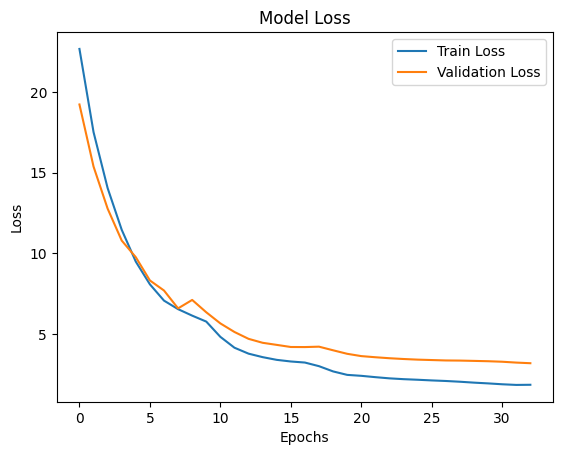

In [ ]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [873]:
y_pred = model.predict(X_val)

4/4 [==============================] - 0s 3ms/step


In [874]:
index = val_split
indexes = list(returns_cleaned.iloc[index:].iloc[:,:-2])

In [875]:
ranking_concat.loc['2021-01-20'].sort_values()

MTS       0
SGRE      1
CIE       2
BBVA      3
ACX_2     4
         ..
DRC      89
SCYR     90
LOR      91
ALB_3    92
GAM_1    93
Name: 2021-01-20 00:00:00, Length: 94, dtype: int64

In [876]:
((y_val+1) * (ranking_concat.max() - ranking_concat.min()).T + ranking_concat.min()).iloc[0].sort_values(ascending=True)

MTS       0.0
ACX_2     1.0
REP       2.0
BKT       3.0
ANA_2     4.0
         ... 
DRC      89.0
LOR      90.0
SCYR     91.0
ALB_3    92.0
GAM_1    93.0
Name: 2021-04-14 00:00:00, Length: 94, dtype: float64

In [877]:
y_pred = pd.DataFrame(y_pred, columns=X.columns,index=y_val.index)
y_pred

,A3TV,ABE,ABG.P_1,ABG,ACS,ACX_1,ACX_2,AENA,AGS,ALB_2,...,TEM,TL5,TRE,TUB,UNF,VIS,VIS_1,VIS_2,VIS_3,ZEL
date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,-0.571540,-0.762733,-0.304129,-0.668816,-0.850812,-0.811052,-0.248041,-0.274617,-0.558702,-0.553227,...,-0.422602,-0.789605,-0.687668,-0.543464,-0.617642,-0.589711,-0.531107,-0.384853,-0.195781,-0.373606
2021-04-21,-0.571676,-0.762663,-0.304057,-0.668610,-0.850785,-0.811123,-0.248103,-0.274586,-0.558603,-0.553358,...,-0.423133,-0.789651,-0.687647,-0.543373,-0.617793,-0.589960,-0.531193,-0.384876,-0.195721,-0.373282
2021-04-28,-0.571694,-0.762510,-0.304068,-0.668560,-0.850822,-0.811204,-0.248093,-0.274575,-0.558609,-0.553566,...,-0.423350,-0.789635,-0.687738,-0.543236,-0.617965,-0.590237,-0.531334,-0.385061,-0.195835,-0.373035
2021-05-05,-0.571753,-0.762417,-0.304006,-0.668396,-0.850685,-0.811193,-0.248106,-0.274572,-0.558504,-0.553655,...,-0.423564,-0.789748,-0.687656,-0.543184,-0.617880,-0.590518,-0.531548,-0.385206,-0.195854,-0.372747
2021-05-12,-0.571832,-0.762289,-0.303919,-0.668276,-0.850613,-0.811252,-0.248079,-0.274608,-0.558404,-0.553747,...,-0.423560,-0.789692,-0.687647,-0.543055,-0.617922,-0.590537,-0.531422,-0.385429,-0.195801,-0.372620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,-0.697437,-0.445891,-0.285075,-0.382922,-0.730239,-0.896118,-0.257205,-0.288401,-0.387406,-0.769285,...,-0.637747,-0.666116,-0.597490,-0.708275,-0.684333,-0.826155,-0.727799,-0.581532,-0.189847,-0.258369
2023-07-17,-0.697437,-0.445891,-0.285075,-0.382922,-0.730239,-0.896118,-0.257205,-0.288401,-0.387406,-0.769285,...,-0.637747,-0.666116,-0.597490,-0.708275,-0.684333,-0.826155,-0.727799,-0.581532,-0.189847,-0.258369
2023-07-24,-0.697437,-0.445891,-0.285075,-0.382922,-0.730239,-0.896118,-0.257205,-0.288401,-0.387406,-0.769285,...,-0.637747,-0.666116,-0.597490,-0.708275,-0.684333,-0.826155,-0.727799,-0.581532,-0.189847,-0.258369


In [878]:
((y_pred+1) * (ranking_concat.max() - ranking_concat.min()).T + ranking_concat.min()).iloc[0].sort_values(ascending=True)

BKT      10.074016
ITX      11.588804
ANA_1    12.072330
SAN_1    12.315727
FER      12.742831
           ...    
CIE      76.676398
CLNX     79.128384
COL_1    80.389668
ALB_3    81.548448
DRC      88.465318
Name: 2021-04-14 00:00:00, Length: 94, dtype: float64

In [855]:
error_total = pd.DataFrame()
in_index = []
for i in range(y_val.shape[0]-1):
    index = y_val.iloc[i].name
    indexes = list(returns.loc[index].dropna().index[:-2])
    ranking_real = np.argsort(np.argsort(-y_val.iloc[i][indexes]))
    ranking_pred = np.argsort(np.argsort(-y_pred.iloc[i][indexes]))

    ranking_real_ordenado = ranking_real.iloc[np.where(ranking_real<10)].index
    ranking_pred_ordenado = ranking_pred.iloc[np.where(ranking_pred<10)] .index   


    int_real_pred = len(set(ranking_real_ordenado).intersection(set(ranking_pred_ordenado)))

    error = ranking_real - ranking_pred
    # error_top = error[ranking_pred_ordenado.index]
    error_total = pd.concat([error_total,error], axis=1)
    in_index.append(int_real_pred)

In [856]:
np.argsort(np.argsort(-y_pred[indexes]))

array([[27,  4,  5, ..., 24, 13, 11],
       [27,  4,  5, ..., 24, 13, 11],
       [27,  4,  5, ..., 24, 13, 11],
       ...,
       [27,  4,  5, ..., 24, 13, 11],
       [27,  4,  5, ..., 24, 13, 11],
       [27,  4,  5, ..., 24, 13, 11]], dtype=int64)

In [857]:
np.argsort(np.argsort(-y_val[indexes]))

array([[17, 30,  8, ..., 18,  1, 12],
       [13, 31, 11, ..., 18,  1,  5],
       [14, 31, 13, ..., 20,  1,  4],
       ...,
       [ 9, 15, 20, ..., 30, 21, 23],
       [ 6, 13, 10, ..., 30, 19, 24],
       [ 7, 13,  9, ..., 29, 20, 27]], dtype=int64)

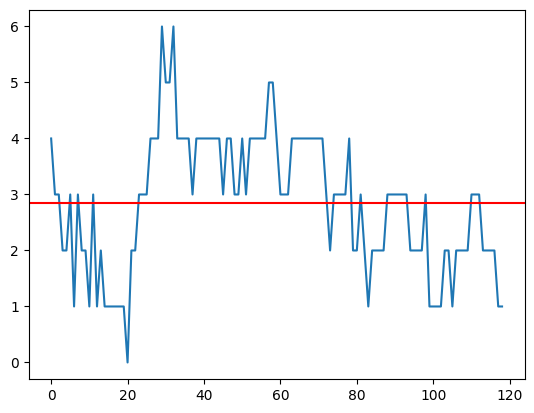

In [858]:
plt.plot(range(y_val.shape[0]-1), in_index)
plt.axhline(xmin=0,xmax=y_val.shape[0], y=np.mean(in_index),c='red');

In [859]:
error_total.columns = y_val[:-1].index

In [860]:
error_total

date,2021-04-14,2021-04-21,2021-04-28,2021-05-05,2021-05-12,2021-05-19,2021-05-26,2021-06-02,2021-06-09,2021-06-16,...,2023-05-29,2023-06-05,2023-06-12,2023-06-19,2023-06-26,2023-07-03,2023-07-10,2023-07-17,2023-07-24,2023-07-31
ACS,-12.0,-17.0,-17.0,-19.0,-21.0,-24.0,-26.0,-23.0,-23.0,-24.0,...,-18.0,-16.0,-17.0,-19.0,-20.0,-18.0,-20.0,-19.0,-18.0,-21.0
ACX_2,27.0,27.0,28.0,27.0,25.0,23.0,24.0,16.0,16.0,10.0,...,11.0,14.0,13.0,16.0,19.0,14.0,17.0,17.0,11.0,9.0
AENA,-1.0,2.0,4.0,7.0,4.0,5.0,4.0,9.0,8.0,1.0,...,16.0,16.0,16.0,17.0,17.0,16.0,15.0,11.0,15.0,5.0
ALM,19.0,21.0,16.0,15.0,21.0,19.0,16.0,12.0,21.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMS_1,-5.0,-6.0,-5.0,-7.0,-5.0,-1.0,-1.0,4.0,4.0,1.0,...,7.0,3.0,4.0,4.0,4.0,4.0,2.0,1.0,-5.0,-4.0
ANA_2,21.0,19.0,19.0,16.0,6.0,5.0,6.0,3.0,4.0,3.0,...,-3.0,-1.0,-1.0,-2.0,2.0,-2.0,-4.0,-2.0,4.0,8.0
BBVA,-5.0,-9.0,-10.0,-9.0,-8.0,-5.0,1.0,1.0,3.0,-4.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
BKT,-3.0,-3.0,-1.0,-23.0,-22.0,-23.0,-25.0,-24.0,-25.0,-28.0,...,-3.0,-3.0,-3.0,-1.0,-3.0,-4.0,-1.0,-3.0,-3.0,-3.0
CABK,14.0,13.0,12.0,19.0,20.0,21.0,21.0,23.0,21.0,20.0,...,20.0,20.0,19.0,20.0,20.0,21.0,21.0,23.0,20.0,13.0
CIE,10.0,22.0,14.0,10.0,11.0,13.0,15.0,16.0,14.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


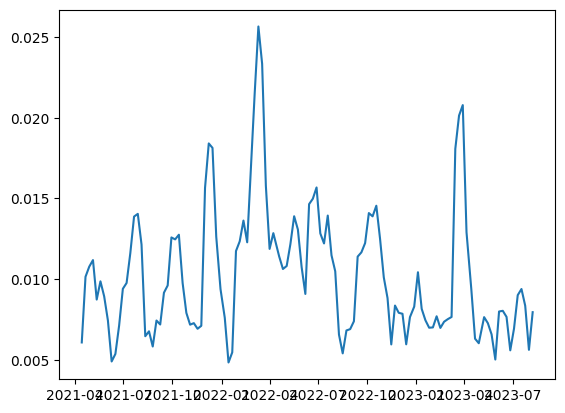

In [861]:
plt.plot(returns['benchmark'].rolling(15,min_periods=15).std()[y_val.index]);

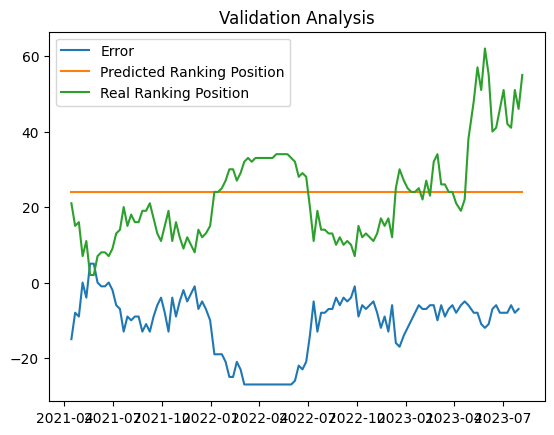

In [862]:
act = 'ITX'
plt.plot(error_total.loc[act],label='Error')
plt.plot(y_val.index, ((y_pred[act]+1) * (ranking_concat[act].max() - ranking_concat[act].min()).T + ranking_concat[act].min()),label='Predicted Ranking Position')
plt.plot(y_val.index, ((y_val[act]+1) * (ranking_concat[act].max() - ranking_concat[act].min()).T + ranking_concat[act].min()),label='Real Ranking Position')
# plt.plot(returns[act].rolling(5,min_periods=1).std()[y_val.index]*1000, c='green');
plt.title('Validation Analysis')
plt.legend();

In [863]:
error_total.mean(axis=1)[(error_total.mean(axis=1)<5) & (error_total.mean(axis=1)>-5)],error_total.std(axis=1)[(error_total.mean(axis=1)<5) & (error_total.mean(axis=1)>-5)]

(AMS_1     3.605042
 BBVA     -3.932773
 MRL       0.689076
 MTS       3.151261
 PHM      -2.495050
 REE_1    -3.200000
 ROVI     -2.024096
 ANE       0.672414
 SCYR_2    1.448276
 dtype: float64,
 AMS_1      6.412671
 BBVA       8.895563
 MRL        6.996062
 MTS        5.518288
 PHM       11.500977
 REE_1     11.481452
 ROVI       8.050111
 ANE        6.760016
 SCYR_2     9.146320
 dtype: float64)

In [864]:
error_total.columns = pd.to_datetime(error_total.columns)

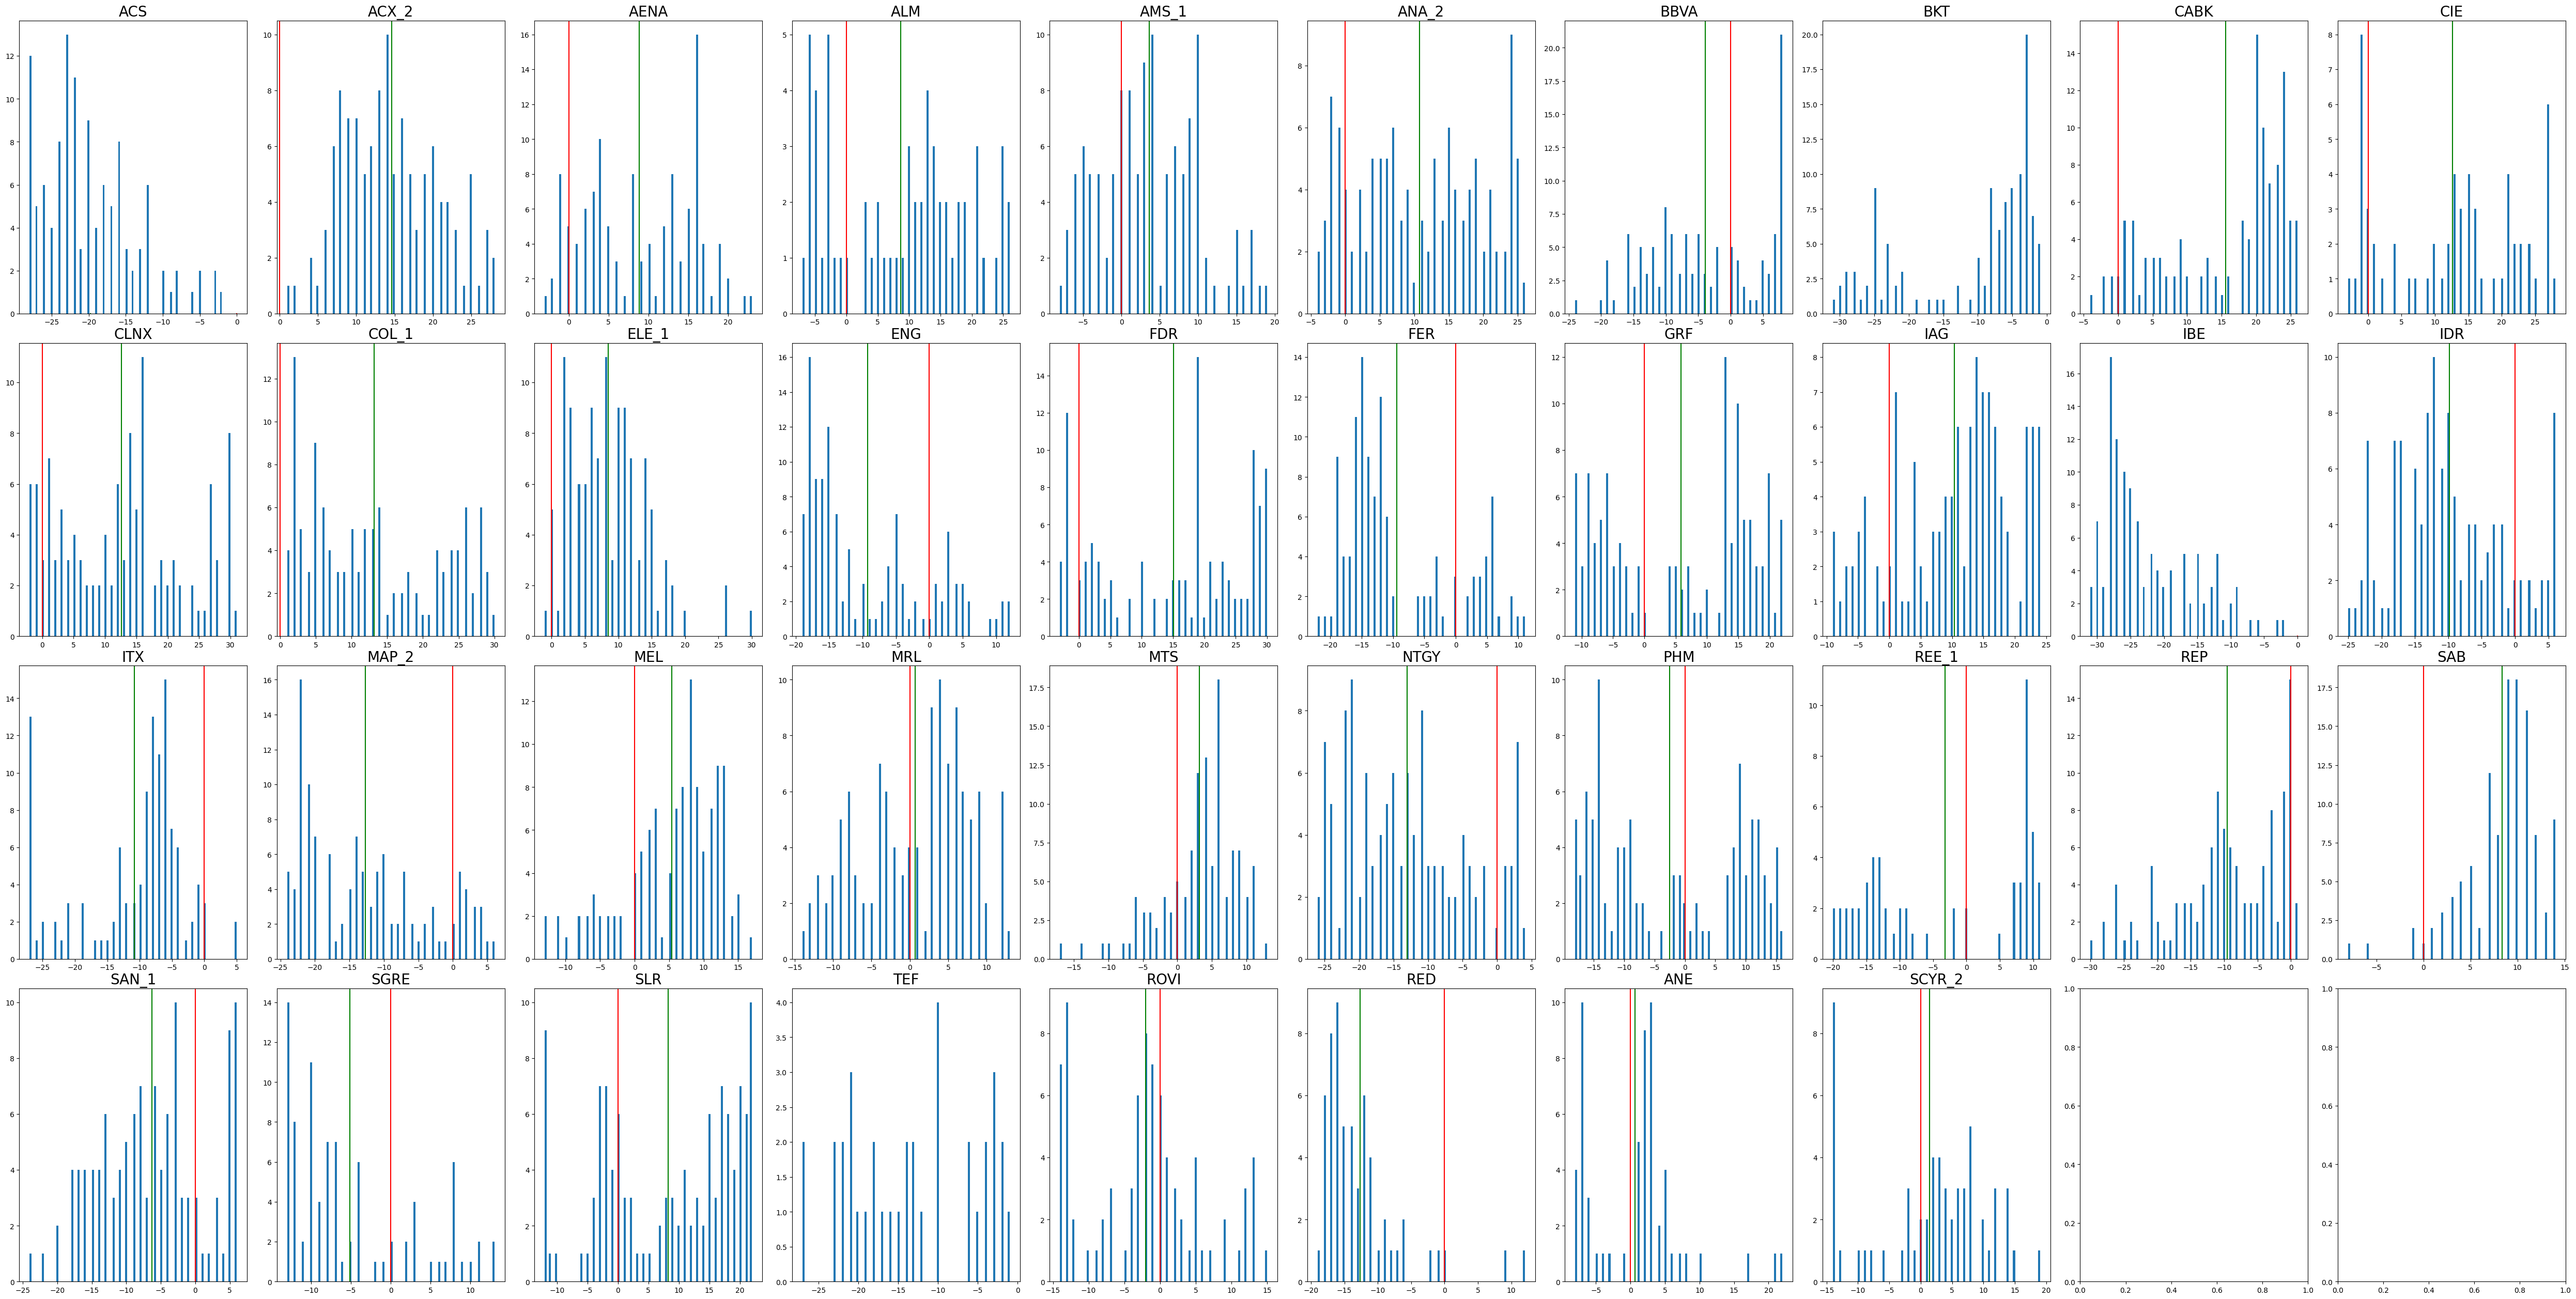

In [865]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=math.ceil(len(error_total.index)/10), ncols=10, figsize=(50, 25))
fig.tight_layout(h_pad=2)
axs = axs.ravel()

for i in range(len(error_total.index)):

    axs[i].hist(error_total.loc[error_total.index[i]].dropna(),bins=100)
    axs[i].axvline(x=0,ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='red')
    axs[i].axvline(x=error_total.loc[error_total.index[i]].dropna().mean(),ymin=0,ymax=error_total.loc[error_total.index[i]].dropna().max()+1,c='green')
    axs[i].set_title(error_total.index[i],fontsize=20)